<center>
<img src="https://image.ajunews.com/content/image/2021/01/25/20210125181044427167.png" width="200" height="200"><br>
</center>

# 시계열 분석을 통한 삼성전자 주가 예측

삼성전자의 주가를 시계열 분석을 사용하여 예측해보고자 한다. 전반적인 내용은 '이것이 데이터 분석이자 with Python'책의 Chapter 3-2. 비트코인 시세 예측하기 부분을 응용한 것이다. 코드에 대한 자세한 기술적인 설명은 다음을 참고한다. 

 - [이것이 데이터 분석이다 with Python: 비트코인 시세 예측](https://unfinishedgod.netlify.app/2021/04/19/python-%EB%B9%84%ED%8A%B8%EC%BD%94%EC%9D%B8-%EC%A3%BC%EA%B0%80-%EC%98%88%EC%B8%A1-study/)

## Step 0 데이터 수집: Yahoo Finance 데이터 불러오기

- 우선 삼성전자 주가의 데이터를 Yahoo Finance모듈에서 불러온다. yfinance모듈을 사용했으며 사용시 데이터의 시작지점은 2019년 1월 부터 2021년 10월 30일까지로 설정 해주었다.
- 삼성전자의 Ticker의 경우 구글에 '삼성전자 주가'를 검색후 나오는 코드인 005930에 '.KS'를 추가해주어 '005930.KS'를 넣어 주었다. 이중에서 종가(Close)를 가져와 price라고 지정해주고 분석을 시작하였다.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


samsung_df = yf.download('005930.KS',
                      start='2019-01-01',
                      end='2021-10-30',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

C:\Users\82104\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


,price
day,
2019-01-02,38750.0
2019-01-03,37600.0
2019-01-04,37450.0
2019-01-07,38750.0
2019-01-08,38100.0
...,...
2021-10-25,70200.0
2021-10-26,71100.0
2021-10-27,70100.0


In [2]:
import warnings
warnings.filterwarnings(action='ignore')

## Step 1 탐색: 시간정보가 포함된 데이터 살펴보기

우선 삼성전자 주가 데이터를 탐색해보자. 다음 코드로 데이터셋을 살펴보면, 삼성전자 주가 데이터는 총 690개의 행으로 이루어진 것을 알 수 있다. 

또한 데이터는 결측값 없이 날짜와 가격의 2개의 피쳐로 구성되어 있다. 

먼저 Train/Test set으로 나눌것인데 마지막 날짜 7일을 제외한 나머지를 Train으로 지정 해주고 마지막 날짜 7일을 Test으로 지정 해주었다. 마지막 일주일의 주식 가격을 예측하고자 한다.

In [3]:
samsung_train_df = samsung_df[:690]
samsung_train_df

,price
day,
2019-01-02,38750.0
2019-01-03,37600.0
2019-01-04,37450.0
2019-01-07,38750.0
2019-01-08,38100.0
...,...
2021-10-14,69400.0
2021-10-15,70100.0
2021-10-18,70200.0


In [4]:
samsung_test_df = samsung_df[690:]
samsung_test_df

,price
day,
2021-10-21,70200.0
2021-10-22,70400.0
2021-10-25,70200.0
2021-10-26,71100.0
2021-10-27,70100.0
2021-10-28,70700.0
2021-10-29,69800.0


## EDA

이제 삼성전자의 데이터를 시각화하여 파악해보았다. 전반적으로 2019년 초부터 2019년 말까지 올라가는 추세를 보이고 있으나, 코로나의 영향으로 2020년 3월 20일날 역사적인 하락세를 보이는 경향을 볼 수 있다. 그러나 그 이후에 점차 회복을 하더니 6만전자, 7만전자.. 기어코 최대 96000만 전자까지 가는 기염을 토했지만 다시 전례 없는 하락세를 보이며 7만원까지 떨어진 모습이다.

In [5]:
# 그래프 폰트 세팅
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Linux':
    path = "/usr/share/fonts/NanumFont/NanumGothic.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

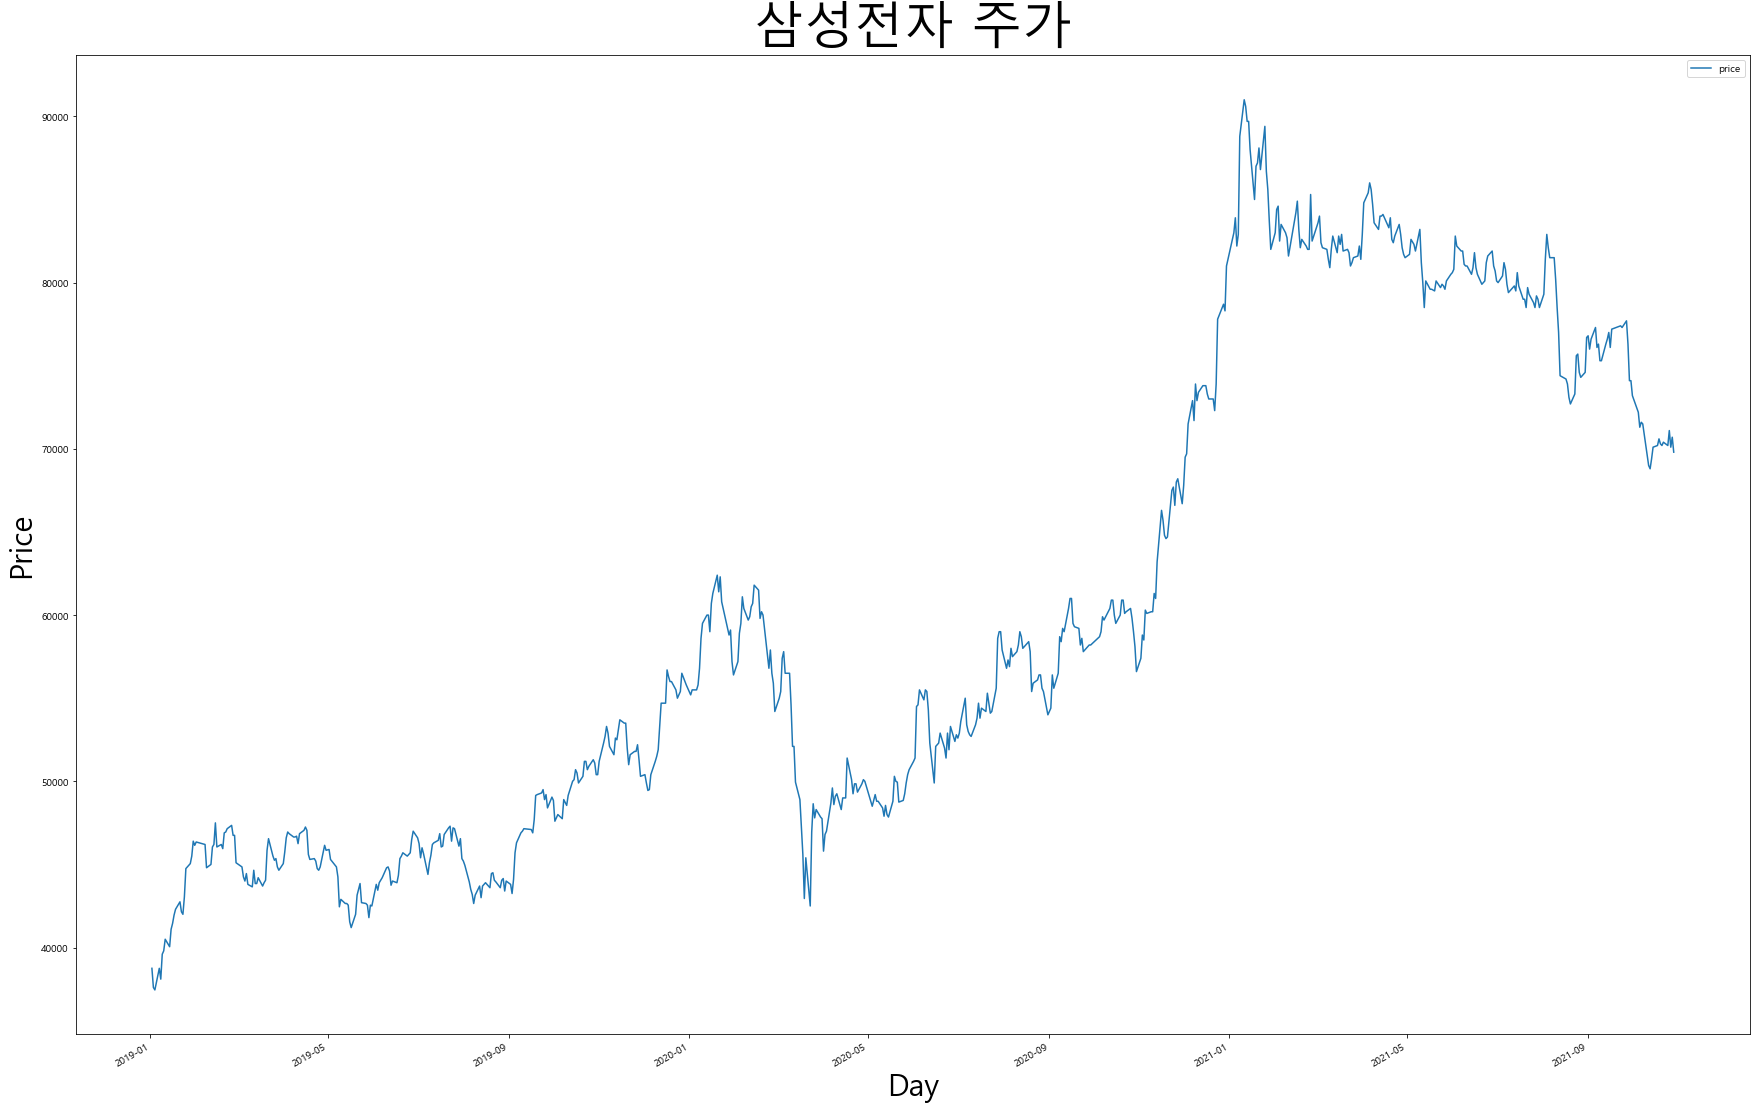

In [6]:
fig, ax = plt.subplots(figsize=(30, 20))
samsung_df.plot(ax=ax)
plt.title("삼성전자 주가",fontsize=50)
plt.xlabel('Day', fontsize=30)
plt.ylabel('Price', fontsize=30)
plt.show()

## Step 2 예측: 파이썬 라이브러리를 활용한 시세 예측

### Model 1: ARIMA

우선 사용할 시계열 예측 분석은 ARIMA 분석 방법이다. ARIMA기법은 전통적인 시계열 예측 방법으로 크게 두 가지 개념을 포함하고 있다. 

- 첫번째는 AR(Autoregression) 모델로 자기 자신의 과거를 정보로 사용하는 개념이다. 이는 '현재의 상태는 이전의 상태를 참고해서 계산된다'라는 아이디어를 기본 전제로 한다. 

- 두번째 개념은 MA(Moving Average)모델로 '이번 항에서의 오차를 이용하여 현재 항의 상태를 추론하자'라는 방법이다. 그리고 이 둘을 합친것을 ARMA 모델이라고 하며, 조금 더 나아간 ARIMA(Autoregressice Integrated Moving Average)모델은 ARMA 모델에 추세 변동의 경향성 까지 반영한 방법이다

파이썬에서는 statsmodel 모듈로 ARIMA 분석을 수행할 수 있다. 다음 코드는 ARIMA 분석의 실행 과정이다. ARIMA 클래스에 order=(2,1,2)라고 입력되어진 파라미터는 'AR이 몇번째 과거까지를 바라보는지에 대한 파라미터 (2), 차분(Defference)에 대한 파라미터(1), MA가 몇 번째 과거까지를 바라보는지에 대한 파라미터(2)'를 의미한다.

차분이란 현재 상태의 변수에서 바로 전 상태의 변수를 빼주는 것을 의미하며, 시계열 데이터의 불규칙성을 조금이나마 보정해주는 역할을 한다. 또한 앞서 말한 ARIMA 모델의 경향성을 의미한다
    
이제 아래의 실행 결과를 분석해보자. 실행 결과의 표를 살펴보면 상수항을 제외한 모든 계수의 p-value( P>|z| )가 0.05이하로 유의미한 것으로 나타난다. 이것은 AR과 MA모두 2로 설정하는 것이 꽤나 의미 있는 분석 결과를 도출한다는 것을 말한다.

In [7]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

model = ARIMA(samsung_train_df.price.values, order = (1,2,1))
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  688
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -5729.799
Method:                       css-mle   S.D. of innovations            996.825
Date:                Tue, 16 Nov 2021   AIC                          11467.598
Time:                        12:25:40   BIC                          11485.733
Sample:                             2   HQIC                         11474.614
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1394      0.200     -0.697      0.486      -0.531       0.253
ar.L1.D2.y     0.0457      0.038      1.198      0.231      -0.029       0.120
ma.L1.D2.y    -1.0000      0.006   -179.351      0.0

### 최적의 AR, D, MA의 값을 찾아내기 위한 함수

p : AR이 몇번째 과거까지 보는지에 대한 파라미터
d : 차분에 대한 파라미터
q : MA가 몇번째 과거까지 보는지에 대한 파라미터

Ordering을 통해 최적의 p, d, q 값을 찾는 함수를 생성하였다.

In [8]:
def my_auto_arima(data, order,sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df

In [9]:
my_auto_arima(samsung_train_df.price.values,[3,3,3])

C:\Users\82104\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


,order,AIC
6,p0 d2 q1,11467.033266
15,p1 d2 q1,11467.598124
7,p0 d2 q2,11467.654730
25,p2 d2 q2,11467.676279
24,p2 d2 q1,11469.337852
16,p1 d2 q2,11469.392949
2,p0 d1 q0,11474.682987
11,p1 d1 q0,11475.288249
3,p0 d1 q1,11475.341480
21,p2 d1 q1,11475.360421


In [10]:
model = ARIMA(samsung_train_df.price.values, order = (0,2,1))
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  688
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -5730.517
Method:                       css-mle   S.D. of innovations            997.821
Date:                Tue, 16 Nov 2021   AIC                          11467.033
Time:                        12:25:46   BIC                          11480.635
Sample:                             2   HQIC                         11472.295
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1399      0.191     -0.732      0.464      -0.515       0.235
ma.L1.D2.y    -1.0000      0.006   -166.495      0.000      -1.012      -0.988
                                    Roots           

---
#### 잠깐: ARIMA 분석의 파라미터 

위 예제의 분석 결과와는 별개로 order 파라미터 p, d, q는 일반적인 가이드라인이 존재한다. 보통은 p와 q의 합이 2 미만인 경우, 혹은 p와 q의 곱이 0을 포함한 짝수인 경우가 좋은 파라미터의 조합이라고 알려져 있다. 

---

다음으로 ARIMA 모델의 학습 결과를 알아보자. 아래의 실행 결과 중 첫 번째 그래프는 학습한 모델에 학습 데이터셋을 넣었을 때의 시계열 예측 결과이다. plot_predic()함수를 사용해보자.

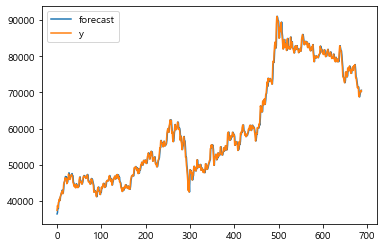

In [11]:
# 핛습 데이터에 대한 예측 결과

fig = model_fit.plot_predict()

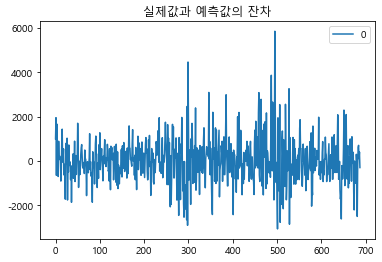

In [12]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title = "실제값과 예측값의 잔차")

이번에는 ARIMA 모델을 평가해보자. 모델을 평가하기 위해서는 테스트 전용 데이터가 필요한데, 이번에는 7일 동안의 미래를 테스트 데이터로 사용해보자. 불규칙적 시계열 예측의 경우에는 먼 미래를 예측하는 것의 큰 의미가 없기 때문에 '앞으로 N일동안 어느정도로 상승/하락할 것이다'정도의 대략적인 경향 예측만을 수행하는 것이 일반적이기 때문이다. 모델의 평가 과정은 다음과 같다.

 - model_fit.forecast(steps = 7)로 향후 7일의 가격을 예측하요 pred_y로 정의 한다. 
 - samsung_df.iloc[690:]로 해주어 samsung_df의 마지막 7일을 test_y로 정의 한다.
 - 모델의 예측한 상한값, 하한값을 pred_y_upper, pred_y_lower로 정의 한다.
 - 정의한 모든 값을 비교하여 7일동안의 상승 경향 예측이 얼마나 맞는지 평가 해본다.

In [13]:
forecast_data = model_fit.forecast(steps=7) 

In [14]:
# 마지막 5일의 예측 데이터 (2021-04-15 ~ 2021-04-19)
pred_arima_y = forecast_data[0].tolist()

# 실제 5일의 데이터 (2021-04-15 ~ 2021-04-19)
test_y = samsung_test_df.price.values

# 마지막 5일의 예측 데이터 최소값
pred_y_lower = []
# 마지막 5일의 예측 데이터 최대값
pred_y_upper = []

for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

그리고 다음 코드는 이를 그래프로 시각화 한 것이다. 파란색 그래프는 모델이 예상한 최고 가격, 즉 상한가의 그래프이다. 그리고 빨간색은 모델이 예측한 하한가 그래프이고, 초록색은 실제 5일간의 가격 그래프, 노란색은 모델이 예측한 가격 그래프를 나타낸 것이다.

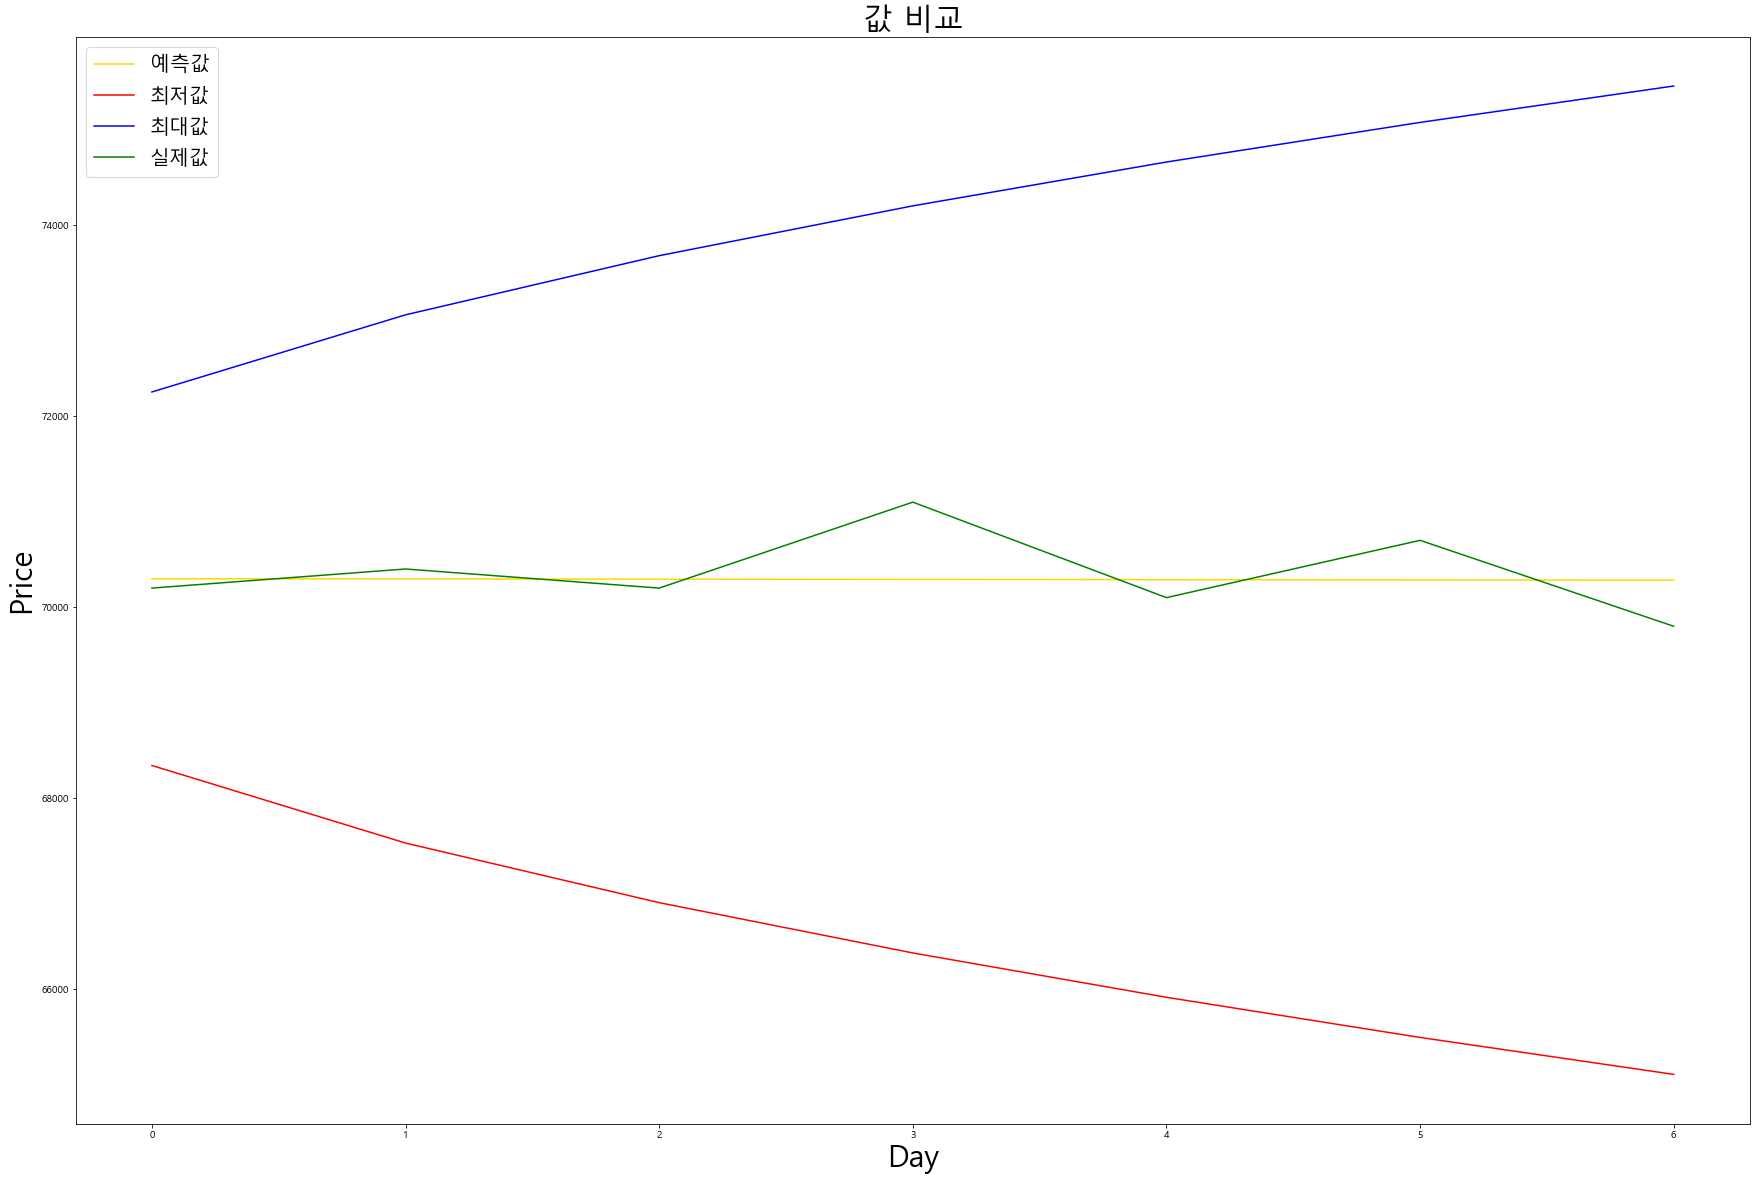

In [15]:
plt.figure(figsize=(30, 20))

# 모델이 예측한 가격 그래프
plt.plot(pred_arima_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')

plt.legend(['예측값', '최저값','최대값','실제값'], fontsize=20)
plt.xlabel('Day', fontsize=30)
plt.ylabel('Price', fontsize=30)
plt.title("값 비교", fontsize=30)
plt.show()

# Model 2: Facebook Prophet

이번에는 ARIMA보다 조금 더 정확한 트렌드 예측 분석을 제공하는 라이브러리 'Facebook Prophet'을 사용해보자. Prophet은 Additive 모델이라는 모델링 방법에 기반한 시계열 예측모델로, 시계열 데이터의 트렌드성(연간/월간/일간)을 예측하는 것에 초점이 맞추어져 있다. 

#### 잠깐: Additive 모델

Additive 모델은 선형회귀 분석의 단점을 극복하기 위해 개량된 분석 방법의 하나이다. 시계열 분석 역시 회귀 분석의 한 갈래이기 때문에 회귀 분석의 단점을 가지고 있다. 하지만 회귀 분석의 단점을 극복하기 위해 이 모델은 각 피쳐마다 비선형적인 적합을 가능하게 하는 일련의 방법을 적용한다. 이는 다소 어렵기 때문에 자세한 사항은 다음을 참고 한다.
 - https://peerj.com/preprints/3190/
 
fbprophet 라이브러리를 사용하기 위해서는 데이터 프레임의 피쳐를 'ds'와 'y'로 변경해야 한다. 그리고 Prophet이라는 클래스를 선언한 뒤, fit() 함수로 모델을 학습시켜준다. 모델 생성에 포함되는 파라미터의 의미는 다음과 같다.

 - sesonality_mode: 연간, 월간, 주간, 일간 등의 트렌드성을 반영하는 것을 의미하는 파라미터
 - changepoint_prior_scale: 트렌드가 변경되는 문맥을 반영하는 파라미터. 수치가 높을수록 모델은 과적합에 가까워진다. 
 

In [16]:
from fbprophet import Prophet


samsung_df = samsung_df.reset_index()

samsung_df.columns = ['ds', 'y']

samsung_train_df = samsung_df[:690]
samsung_test_df = samsung_df[690:]

In [17]:
prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=False, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)

prophet.fit(samsung_train_df)

그리고 다음코드에서 make_future_dataframe(periods=5, freq='d'), prophet.predict(future_data)를 실행하면 학습 데이터 셋 기반의 5일 단위 예측 데이터를 얻을 수 있다.

In [18]:
future_data = prophet.make_future_dataframe(periods = 7, freq = 'd')
forecast_data = prophet.predict(future_data)
forecast_data[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
690,2021-10-21,73176.655314,71095.361102,75302.464362
691,2021-10-22,73094.758162,71043.379845,75183.548897
692,2021-10-23,63818.031263,61761.611777,65914.969794
693,2021-10-24,63770.949235,61711.628121,65788.858808
694,2021-10-25,73008.839157,70883.540715,75323.504562
695,2021-10-26,73070.150415,70844.524221,75443.958505
696,2021-10-27,72922.181591,70586.916647,75290.644410


다음은 이 fbprophet 모델의 학습 결과를 시각화한 결과이다. 그래프의 검은 점은 실제 가격을 나타낸 것이고, 파란 선은 예측 가격을 나타낸 것이다. 이 모델 역시 ARIMA 모델과 마찬가지로 학습 데이터셋에 대해서는 거의 정확한 예측을 하고 있다. 하지만 시계열 데이터 분석에서 학습 데이터를 잘 예측하는건 큰 의미가 없다.

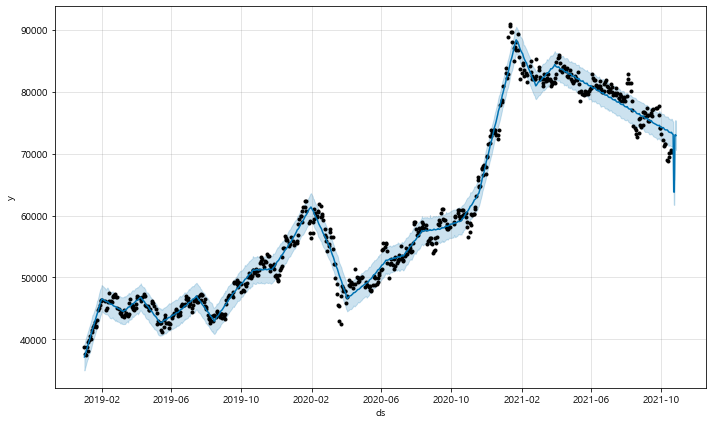

In [19]:
fig1 = prophet.plot(forecast_data)

그리고 다음 그래프는 fbprophet에서 제공하는 트렌드 정보 시각화 그래프이다. 앞서 seasonality_mode 파라미터를 설정해놓은 경우에만 이 시각화가 가능하다. 우리는 이를 통해 시계열 데이터가 어떤 흐름을 가지고 변화하는지를 살펴볼 수 있다. 전체적인 데이터의 트렌드는 아래의 첫 번째 그래프로 살펴볼 수 있고, 이어지는 그래프에서는 year, weekly, daily 순의 트렌드를 확인할 수 있다.

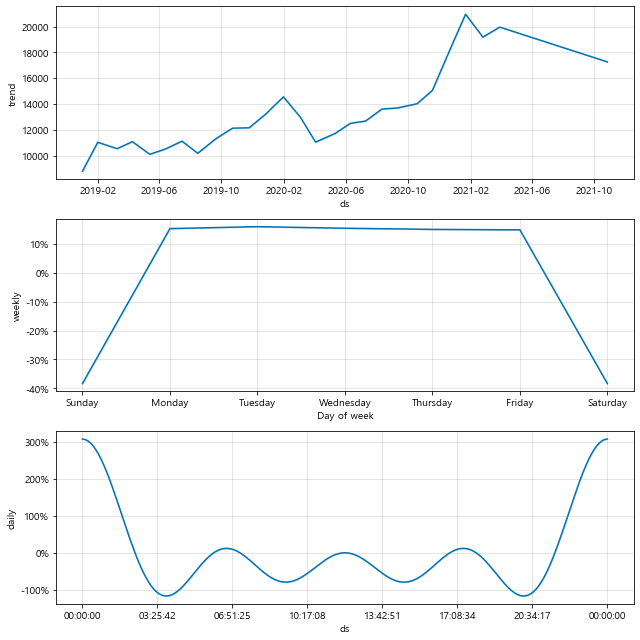

In [20]:
fig2 = prophet.plot_components(forecast_data)

#### Testset 평가

이번에는 테스트셋을 평가 해보자. 다음 코드의 실행 결과를 보자.

Text(0.5, 1.0, '값 비교')

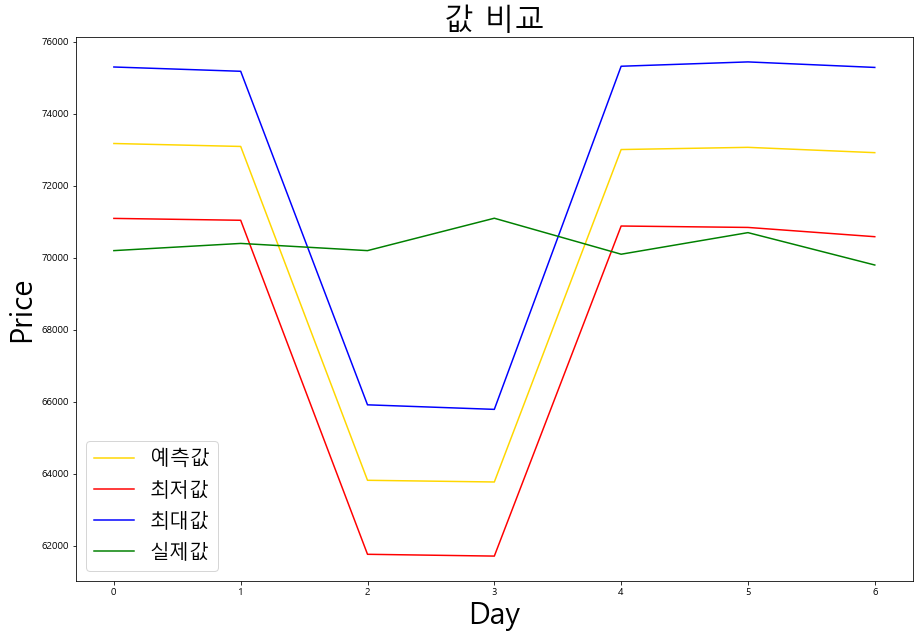

In [21]:
plt.figure(figsize=(15, 10))

# 마지막 7일의 예측 데이터
pred_fbprophet_y = forecast_data.yhat.values[-7:]

# 실제 7일의 데이터
test_y = samsung_test_df.y.values

# 마지막 7일의 예측 데이터 최소값
pred_y_lower = forecast_data.yhat_lower.values[-7:]
# 마지막 7일의 예측 데이터 최대값
pred_y_upper = forecast_data.yhat_upper.values[-7:]

# 모델이 예측한 가격 그래프
plt.plot(pred_fbprophet_y, color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(pred_y_lower, color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(pred_y_upper, color = 'blue')

# 실제 가격 그래프
plt.plot(test_y, color = 'green')
plt.legend(['예측값', '최저값','최대값','실제값'], fontsize=20)
plt.xlabel('Day', fontsize=30)
plt.ylabel('Price', fontsize=30)
plt.title("값 비교", fontsize=30)

## Step 3 활용: 더나은 결과를 위한 방법

이번에는 모델의 성능을 조금 더 향상시킬 수 있는 방법에 대해 알아보자. 첫 번째로 고려해볼 방법은 상한값 혹은 하한값을 지정해주는 것이다. 바닥과 천장이 없는 주가 데이터의 경우 의미가 없을 수 있지만 일반적인 시계열 데이터에서는 상한값 혹은 하한값을 설정해 주는 것이 모델의 성능을 높여줄 수 있는 방법중 하나이다. <br>
 Prophet 모델에서 future_data['cap'] = 96000 통해 데이터넷에 상한선을 설정할 수 있다. 다음 코드와 실행 결과는 상한선을 적용할 학습 결과를 시각화 한 것이다.

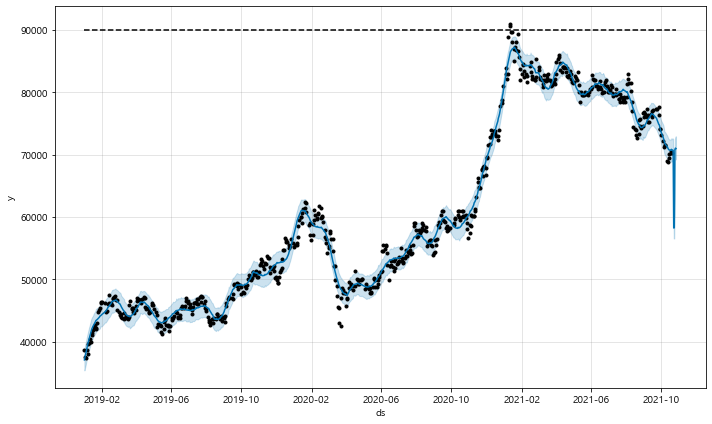

In [22]:
# 상한가 설정
samsung_train_df['cap'] = 90000

# 상한가 적용을 위한 파라미터를 다음과 같이 설정
prophet = Prophet(seasonality_mode = 'multiplicative',
                 growth = 'logistic',
                 yearly_seasonality = True,
                 weekly_seasonality = True, 
                 daily_seasonality = True,
                 changepoint_prior_scale = 0.5)

prophet.fit(samsung_train_df)

# 5일 예측 
future_data = prophet.make_future_dataframe(periods = 7, freq = 'd')

# 상한가 설정
future_data['cap'] = 90000
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)

#### 이상치 제거

이번에는 모델의 성능을 향상시키는 다른 방법중 하나인 이상치 제거 기법을 살펴보자. 이상치란 평균적인 수치에 비해 지나치게 높거나 낮은 수치의 데이터를 의미한다. fbprophet 모델이 이상치를 제거한 데이터로 학습하려면 이상치에 해당하는 데이터를 None로 설정해주면 된다. 이번에는  63000이 넘는 데이터를 이상치라고 설정 해주었다. 

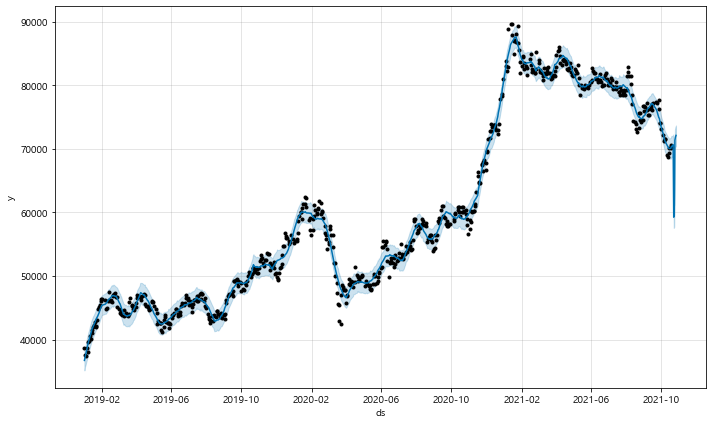

In [23]:
samsung_train_df.loc[samsung_train_df['y'] > 90000, 'y'] = None

# prophet 모델 학습
prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality = True,
                 weekly_seasonality = True,
                 daily_seasonality = True,
                 changepoint_prior_scale = 0.5)

prophet.fit(samsung_train_df)

# 5일 예측 
future_data = prophet.make_future_dataframe(periods = 7, freq = 'd')

forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)

In [24]:
pred_fbprophet_y_1 = forecast_data.yhat.values[-7:]

## Step 4: Model  평가

지금까지 ARIMA, FBprophet, 이상치를 제거한 FBprophet모델을 가지고 삼성전자 주가를 예측 해보았다. 이제는 각각의 모델이 삼성전자 주가를 어떻게 예측을 하고 있는지 비교를 해보자.

#### RMSE

평균 제곱근 오차(Root Mean Square Error; RMSE)를 의미하는 RMSE를 구해보자.

In [25]:
df = pd.DataFrame({'ARIMA 예측값':pred_arima_y,
                   'FBprophet 예측값':  pred_fbprophet_y,
                   'FBprophet 이상치 제거 후(90000) 예측값':pred_fbprophet_y_1,
                   '실제값':test_y})

df

,ARIMA 예측값,FBprophet 예측값,FBprophet 이상치 제거 후(90000) 예측값,실제값
0,70297.927905,73176.655314,70498.923947,70200.0
1,70295.715866,73094.758162,70656.188712,70400.0
2,70293.363884,63818.031263,59257.121545,70200.0
3,70290.871959,63770.949235,59501.165011,71100.0
4,70288.240090,73008.839157,71372.121830,70100.0
5,70285.468279,73070.150415,71878.051962,70700.0
6,70282.556524,72922.181591,72132.437615,69800.0


#### 모델별 예측값 시각화

이번에는 모델별 예측한 값들을 비교 해보자. 다음 그림을 통해 확인할 수 있듯 ARIMA모델이 가장 좋은 효과를 보이는걸로 나타났다.

Text(0.5, 1.0, '값 비교')

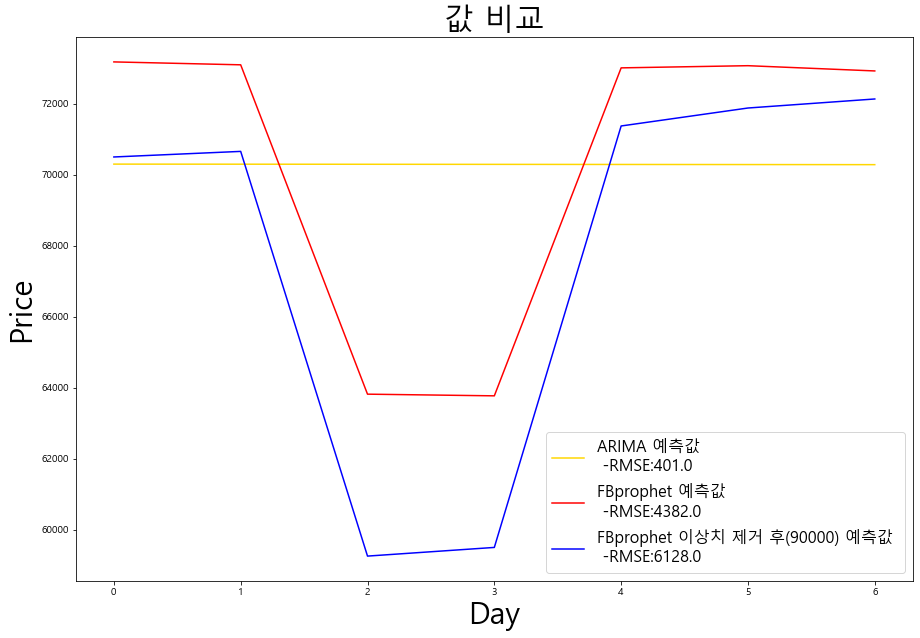

In [26]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

plt.figure(figsize=(15, 10))

# arima 모델의  rmse
rmse_arima = sqrt(mean_squared_error(pred_arima_y, test_y))

# fbprophet 모델의  rmse
rmse_fbprophet = sqrt(mean_squared_error(pred_fbprophet_y, test_y))

# 전처리 진행한 fbprophet 모델의  rmse
rmse_fbprophet_1 = sqrt(mean_squared_error(pred_fbprophet_y_1, test_y))

# 모델이 예측한 가격 그래프
plt.plot(df[['ARIMA 예측값']], color = 'gold')

# 모델이 예측한 최저 가격 그래프
plt.plot(df[['FBprophet 예측값']], color = 'red')

# 모델이 예측한 최고 가격 그래프
plt.plot(df[['FBprophet 이상치 제거 후(90000) 예측값']], color = 'blue')

# 실제 가격 그래프
# plt.plot(test_y, color = 'green')

plt.rc('legend', fontsize=16)
plt.legend(['ARIMA 예측값 \n -RMSE:' + str(round(rmse_arima,0)), 
            'FBprophet 예측값  \n -RMSE:' + str(round(rmse_fbprophet,0)),
            'FBprophet 이상치 제거 후(90000) 예측값 \n -RMSE:' + str(round(rmse_fbprophet_1,0))])
plt.xlabel('Day', fontsize=30)
plt.ylabel('Price', fontsize=30)
plt.title("값 비교", fontsize=30)

# 총평

'이것이 데이터 분석이다 with python'을 통해 bitcoin 시세 예측 코드를 비탕으로 이를 응용해서 삼성전자의 주가를 예측 해보았다.

ARIMA보다 FBprophet모델이 더 좋은 성능을 보인다고 알려져 있지만 이번에는 왜인지 ARIMA가 가장 좋게 나오는 경향을 보인다. 

사후적 고찰하면, FBprophet 모델이 계절성, 주기성을 크게 반영하고 있기에 마지막 일주일에서도 주별 주가 변동을 크게 반영하여 오차가 커진 것으로 예상된다. 파라미터 조절을 통해 개선될 수 있으리라고 생각된다.